# Trabajo Final de Aprendizaje de Máquina

### Walmart Recruiting: Trip Type Classification


**J. Adrián Sánchez Castro**   116369<br>
**Nohemí Limnones Calvillo**    136135<br>
**Manuel Ríos Zagal**           159284<br>


#### Diciembre, 2016

Instituto Tecnológico Autónomo de México

## Introducción

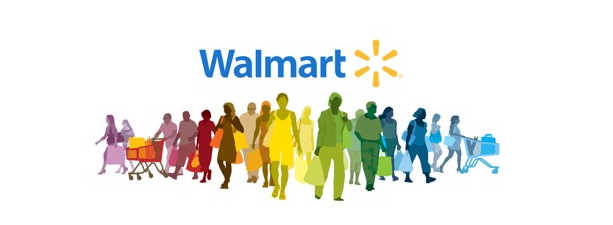

In [1]:
from IPython.display import Image
Image("walmart.png")

El proyecto final consiste en clasificar tipos de viajes de compras basándose en los artículos que compraron los clientes. Para dar algunos ejemplos hipotéticos de tipos de viaje: un cliente puede hacer un pequeño viaje diario para la cena, un viaje semanal para compra de muchos comestibles, un viaje para comprar regalos para unas próximas vacaciones, o un viaje temporada para comprar ropa.

Walmart ha categorizado los viajes contenidos en estos datos en 38 distintos tipos usando un método patentado aplicado a un conjunto extendido de datos. Se le reta a recrear esta categorización / agrupación con un conjunto más limitado de características.


Para resolver el proyecto se utilizarán 3 algoritmos de aprendizaje máquina: Regresión Logística, Bosques Aleatorios y K-Vecinos Cercanos. El objetivo es tratar de lograr el mayor porcentaje de certeza en la predicción del tipo de viaje.

Este proyecto es entregado en un *Ipython Jupyter Notebook* que se encuentra dividido en cuatro secciones.

- **Sección 1.** Análisis Exploratorio de Datos
- **Sección 2.** Limpieza y Transformación de Datos<br>
- **Sección 3.** Modelado
- **Sección 4.** Análisis de Resultados

## Importación de modulos

In [2]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import scipy
import sklearn

## Sección 1. Análisis Exploratorio de Datos de base de entrenamiento

In [3]:
data = pd.read_csv("data/train.csv")
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [4]:
data.shape

(647054, 7)

### Valores NA's en nuestra base

In [5]:
data.count()

TripType                 647054
VisitNumber              647054
Weekday                  647054
Upc                      642925
ScanCount                647054
DepartmentDescription    645693
FinelineNumber           642925
dtype: int64

In [6]:
print(647054-642925)
print(4129/647054)

4129
0.006381229387346342



Podemos ver que hay **4129** filas que se encuentran **vacías **y representan al rededor **.6%** y que podemos remover 

### Tirar los NA's

In [7]:
data = data.dropna()
len(data)

642925

In [8]:
data.count()

TripType                 642925
VisitNumber              642925
Weekday                  642925
Upc                      642925
ScanCount                642925
DepartmentDescription    642925
FinelineNumber           642925
dtype: int64

In [9]:
data.shape

(642925, 7)

### Tipos de visitas

In [10]:
len(data.TripType.unique())

38

In [11]:
x = data.TripType.unique()
np.sort(x)

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

Recordemos que teníamos **38 tipos de visitas**. Nos interesaría saber qúe tipo de visitas son las **más populares**. O también, nos interesaría saber si las visitas están **distribuidas uniformemente**.

In [12]:
df_tipo_visita = data.drop_duplicates("VisitNumber")

In [13]:
df_tipo_visita.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
26,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
29,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


In [14]:
x = df_tipo_visita["TripType"]
x = x.value_counts()

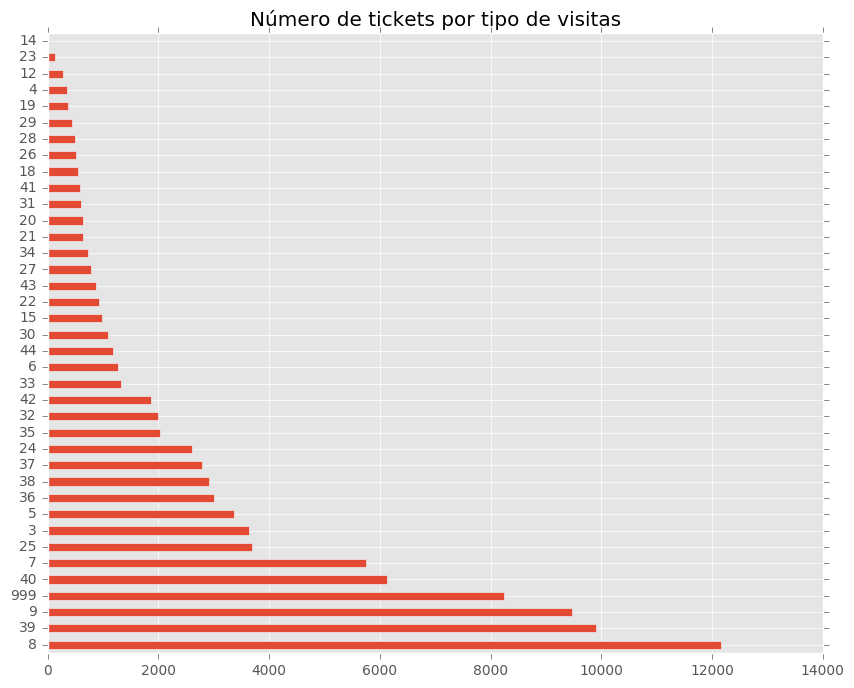

In [15]:
graph = x.plot(kind="barh", figsize=(10, 8))
graph.set_title("Número de tickets por tipo de visitas")

Poemos ver que alrededor de **6 tipos** de tipos de visita contienen la mayoría de visitas. Que serían el 7, 40, 999, 9, 39, y 8

### Número de vistas

In [16]:
len(data.VisitNumber.unique())

94247

### Número de compras

In [17]:
h = data.ScanCount.unique()
h[::-1].sort()
h

array([ 71,  51,  46,  31,  30,  25,  24,  23,  22,  20,  19,  18,  17,
        16,  15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,
         3,   2,   1,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -9, -10, -12])

Podemos ver que existen **valores negativos** que implican productos devueltos. Hay algun producto que fue comprado en una misma vez 71 veces, y también hay un producto que fue devuelto 12 veces.

### Tipos de departamento

In [18]:
data.DepartmentDescription.unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP',
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',
    

Estas son las clasificaciones que Walmart le asignó a a cada producto comprado, es decir, son una clasificación que describe qué tipo de producto es dado el tipo de departamento al cuál pertencen.

In [19]:
len(data.DepartmentDescription.unique())

68

Vemos que hay 69 tipos de productos. Es decir, hay 69 distintos departamentos ligados a cada producto

### Número de productos

In [20]:
len(data.Upc.unique())

97714

### Categorías para productos

In [21]:
len(data.FinelineNumber.unique())

5195

Tenemos otras categorias que Walmart definió y que hay 5196 categorias asignadas para 97715 productos.

### Anáisis del tipo de visita y producto

1. Nos interesaría entender que **tipo de productos compran por visita**.

Veamos que el **tipo de visita 9** corresponde a **qué tipo de productos** basados en su departamento.

In [22]:
tipo_visita_9 = data[data.TripType == 9]
tipo_visita_9.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
66,9,23,Friday,4.011000e+03,1,PRODUCE,5501.0
67,9,23,Friday,6.922496e+11,1,HOME MANAGEMENT,3005.0
89,9,30,Friday,9.933894e+09,1,LADIESWEAR,1180.0
116,9,50,Friday,3.825775e+09,1,MENS WEAR,8218.0
143,9,68,Friday,4.282560e+09,1,MENS WEAR,8225.0


In [23]:
tipo_visita_9_departamento = tipo_visita_9[["TripType","DepartmentDescription"]]
tipo_visita_9_departamento.head()

,TripType,DepartmentDescription
66,9,PRODUCE
67,9,HOME MANAGEMENT
89,9,LADIESWEAR
116,9,MENS WEAR
143,9,MENS WEAR


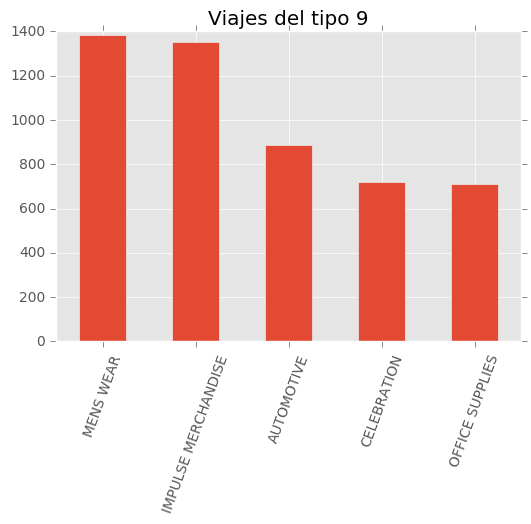

In [24]:
tipo_visita_9_departamento.DepartmentDescription.value_counts().head().plot(kind="bar", rot=70, title="Viajes del tipo 9")

De esta manera vemos que esta muy ligado diversos tipos de productos y este tipo de analisis no funciona mucho para entender que tipo de productos están compuestos. 
Este tipo de análisis lo pudieramos hacer para cada una de los 38 tipos de visita, pero es algo que mejor deberiamos dejar para nuestros modelos.

## Sección 2. Limpieza y Transformación de Datos

## Conjunto de Entrenamiento

In [25]:
#Importamos la base con pandas Data Frame para el conjunto de entrenamiento
train = pd.read_csv("data/train.csv")
train.columns = ['tipo_visita', 'ticket', 'dia', 'producto', 'items_comprados', 'departamento', 'categoria']
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [26]:
train.shape

(647054, 7)

## Tirar los NA's

In [27]:
train = train.dropna()
len(train)

642925

In [28]:
train.shape

(642925, 7)

### Dummies por departamento

In [29]:
#Creamos dummies de cada tipo de producto definido por el departamento
dummies_train = pd.get_dummies(train.departamento)
dummies_train.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
dummies_train.shape

(642925, 68)

In [31]:
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [32]:
train[dummies_train.columns] = dummies_train 

In [33]:
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Reasignamos los valores de los días de  la semana por un valor entero

In [34]:
train['dia'] = train['dia'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,999,5,5,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,7,5,6.053882e+10,1,SHOES,8931.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,7,5,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,5,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,5,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
train.shape

(642925, 75)

## Total de productos por departamento por ticket

In [36]:
#Creación de un dataframe que ligue las categorias de producto por ticket
data_dummies_train = train.iloc[:,7:]
data_dummies_train.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
data_dummies_train.shape

(642925, 68)

In [38]:
data_dummies_train = data_dummies_train.apply(lambda x: x*train["items_comprados"])
data_dummies_train = data_dummies_train.replace(-0,0)
data_dummies_train.describe()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,...,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000
mean,0.000705,0.001935,0.008502,0.012916,0.007623,0.023451,0.003689,0.001526,0.005716,0.002708,...,0.003425,0.000042,0.016762,0.000827,0.008951,0.003430,0.008001,0.000919,0.009659,0.002489
std,0.038088,0.051112,0.114137,0.139105,0.107961,0.176328,0.080005,0.043659,0.083587,0.059555,...,0.070268,0.006716,0.142865,0.042906,0.120048,0.068394,0.117212,0.037006,0.125919,0.058470
min,-2.000000,-2.000000,-6.000000,-6.000000,-3.000000,-9.000000,-2.000000,-2.000000,-3.000000,-3.000000,...,-1.000000,-1.000000,-2.000000,-2.000000,-3.000000,-2.000000,-5.000000,-1.000000,-10.000000,-2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,9.000000,12.000000,12.000000,10.000000,20.000000,12.000000,7.000000,4.000000,4.000000,...,11.000000,1.000000,7.000000,10.000000,51.000000,15.000000,20.000000,2.000000,16.000000,4.000000


In [39]:
data_dummies_train.shape

(642925, 68)

In [40]:
#Creando dummie especial si hubo algun retorno de producto
train.loc[train.items_comprados < 0, 'devolución'] = 1
train.loc[train.devolución != 1, 'devolución'] = 0
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,devolución
0,999,5,5,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,30,7,5,6.053882e+10,1,SHOES,8931.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,7,5,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,5,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,5,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
train = train[["tipo_visita", "ticket", "dia", "items_comprados", "devolución"]]

In [42]:
train.shape

(642925, 5)

## Concatenar bases

In [43]:
train = pd.concat([train, data_dummies_train], axis=1)
train.head()

,tipo_visita,ticket,dia,items_comprados,devolución,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,999,5,5,-1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,7,5,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,7,5,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,5,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,5,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
train.shape

(642925, 73)

## Agrupamiento por ticket por tipo de producto por departamento

In [45]:
grouped = train.groupby("ticket")

In [46]:
grouped = grouped.agg({'dia': np.max, "tipo_visita": np.max, 'items_comprados': np.sum, 'devolución': np.max, 
              '1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum,
       'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
       'BOOKS AND MAGAZINES': np.sum, 'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum,
       'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum,
       'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 'DSD GROCERY': np.sum,
       'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 'FINANCIAL SERVICES': np.sum,
       'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 'HOME DECOR': np.sum,
       'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
       'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
       'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
       'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,
       'LARGE HOUSEHOLD GOODS': np.sum, 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum,
       'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum, 'MENS WEAR': np.sum, 'MENSWEAR': np.sum,
       'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
       'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
       'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
       'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
       'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum,
       'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 'SPORTING GOODS': np.sum,
       'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})

In [47]:
train = grouped[["tipo_visita", "dia", "items_comprados", "devolución", 'ACCESSORIES',
               'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
               'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
               'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
               'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
               'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
               'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
               'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
               'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
               'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
               'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
               'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
               'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
               'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR',
               'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
               'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
               'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
               'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
               'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
               'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
               'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]

In [48]:
train['tipo_visita'] = train['tipo_visita'].map({3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 12:7, 14:8, 15:9,  
                                         18:10, 19:11, 20:12, 21:13, 22:14, 23:15, 24:16, 25:17, 26:18,  
                                         27:19, 28:20, 29:21, 30:22, 31:23, 32:24, 33:25, 34:26, 35:27, 
                                         36:28, 37:29, 38:30, 39:31, 40:32, 41:33, 42:34, 43:35, 44:36, 999:37})

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
train.head(5)

,tipo_visita,dia,items_comprados,devolución,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
ticket,,,,,,,,,,,,,,,,,,,,,
5,37,5,-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22,5,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,18,5,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


De esta manera, tenemos un dataframe que agrupo por cada id de ticket con el día de compra y el tipo de producto que se compró

In [50]:
train.shape

(94247, 70)

# Conjunto de Prueba

In [51]:
#Importamos la base con pandas Data Frame para el conjunto de prueba
test = pd.read_csv("data/test.csv")
test.columns = ['ticket', 'dia', 'producto', 'items_comprados', 'departamento', 'categoria']
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


## Tirar los NA's

In [52]:
test.shape

(653646, 6)

In [53]:
#test = test.dropna()
#test.shape

In [54]:
#Creamos dummies de cada tipo de producto definido por el departamento
dummies_test = pd.get_dummies(test.departamento)
test[dummies_test.columns] = dummies_test 
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,1,Friday,7.250339e+10,1,SHOES,3002.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
test.shape

(653646, 73)

In [56]:
dummies_test.shape

(653646, 67)

In [57]:
dummies_test.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Reasignamos los valores de los días de  la semana por un valor entero

In [58]:
test['dia'] = test['dia'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,1,5,7.250339e+10,1,SHOES,3002.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,5,1.707711e+09,1,DAIRY,1526.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,8.947000e+10,1,DAIRY,1431.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,8.849121e+10,1,GROCERY DRY GOODS,3555.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,2.840015e+09,1,DSD GROCERY,4408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
#Creación de un dataframe que ligue las categorias de producto por ticket
data_dummies_test = test.iloc[:,6:]
data_dummies_test.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
data_dummies_test = data_dummies_test.apply(lambda x: x*test["items_comprados"])
data_dummies_test = data_dummies_test.replace(-0,0)
data_dummies_test.describe()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,...,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000
mean,0.000704,0.002035,0.008465,0.012585,0.007539,0.023510,0.003488,0.001388,0.005783,0.002613,...,0.003739,0.000046,0.016336,0.000944,0.008908,0.003540,0.007773,0.000938,0.009548,0.002408
std,0.046142,0.052757,0.117342,0.135384,0.109231,0.173454,0.076787,0.040113,0.085319,0.058403,...,0.073684,0.010048,0.142642,0.050884,0.102109,0.069109,0.110972,0.036909,0.124867,0.059630
min,-6.000000,-8.000000,-3.000000,-2.000000,-5.000000,-14.000000,-6.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-3.000000,-4.000000,-7.000000,-3.000000,-2.000000,-4.000000,-1.000000,-3.000000,-2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,7.000000,16.000000,13.000000,19.000000,12.000000,12.000000,4.000000,12.000000,4.000000,...,13.000000,3.000000,6.000000,18.000000,6.000000,14.000000,11.000000,2.000000,20.000000,10.000000


In [61]:
data_dummies_test.shape

(653646, 67)

In [62]:
#Creando dummie especial si hubo algun retorno de producto
test.loc[test.items_comprados < 0, 'devolución'] = 1
test.loc[test.devolución != 1, 'devolución'] = 0
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,devolución
0,1,5,7.250339e+10,1,SHOES,3002.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,1.707711e+09,1,DAIRY,1526.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,8.947000e+10,1,DAIRY,1431.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,8.849121e+10,1,GROCERY DRY GOODS,3555.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,2.840015e+09,1,DSD GROCERY,4408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
test = test[["ticket", "dia", "items_comprados", "devolución"]]

In [64]:
test.shape

(653646, 4)

## Concatenación con base de dummies

In [65]:
test = pd.concat([test, data_dummies_test], axis=1)
test.head()

,ticket,dia,items_comprados,devolución,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
test.shape

(653646, 71)

## Agrupamiento por ticket por tipo de producto por departamento

In [67]:
grouped = test.groupby("ticket")

In [68]:
grouped = grouped.agg({'dia': np.max, 'items_comprados': np.sum, 'devolución': np.max,'1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum,
       'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
       'BOOKS AND MAGAZINES': np.sum, 'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum,
       'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum,
       'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 'DSD GROCERY': np.sum,
       'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 'FINANCIAL SERVICES': np.sum,
       'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 'HOME DECOR': np.sum,
       'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
       'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
       'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
       'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,
       'LARGE HOUSEHOLD GOODS': np.sum, 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum,
       'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum, 'MENS WEAR': np.sum, 'MENSWEAR': np.sum,
       'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
       'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
       'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
       'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
       'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum,
       'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 'SPORTING GOODS': np.sum,
       'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})

In [69]:
test = grouped[["dia", "items_comprados", "devolución", 'ACCESSORIES',
               'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
               'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
               'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
               'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
               'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
               'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
               'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
               'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
               'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
               'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
               'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
               'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
               'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR',
               'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
               'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
               'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
               'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
               'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
               'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
               'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]

In [70]:
test.shape

(95674, 69)

## Columna de total de tipos de productos comprados

In [71]:
def category_count_train(data):
    """# Para cada fila a partir de la columna 4, 
    suma uno por cada tipo de producto comprado en una lista y lo apendea en una lista
    """
    alist = []
    for array in np.asarray(data.iloc[:,4:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"total_tipo_productos"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(4, 'total_categorias_compradas', cat_counts)
    
    return data

In [72]:
train = category_count_train(train)

In [73]:
print(train.shape)
train.head()

(94247, 71)


,tipo_visita,dia,items_comprados,devolución,total_categorias_compradas,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
ticket,,,,,,,,,,,,,,,,,,,,,
5,37,5,-1,1.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22,5,2,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,18,5,27,1.0,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5,5,3,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5,5,3,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
def category_count_test(data):
    """# Para cada fila a partir de la columna 4, 
    suma uno por cada tipo de producto comprado en una lista y lo apendea en una lista
    """
    alist = []
    for array in np.asarray(data.iloc[:,3:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"total_tipo_productos"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'total_categorias_compradas', cat_counts)
    
    return data

In [75]:
test = category_count_test(test)

In [76]:
print(test.shape)
test.head()

(95674, 70)


,dia,items_comprados,devolución,total_categorias_compradas,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
ticket,,,,,,,,,,,,,,,,,,,,,
1,5,4,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5,4,0.0,3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Hold-Out Validation

In [77]:
from sklearn.cross_validation import train_test_split

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [78]:
#Separamos la base de datos original de train en train y test nuevamente 
train_2,test_2 = train_test_split(train, test_size=0.3)

In [79]:
#Vamos a separar las variables explicativas(x`s) y la variable a predecir(y) en las dos bases

#Base de train
y_train = train_2["tipo_visita"]
x_train = train_2.drop("tipo_visita", axis=1).values.astype(float)

#Base de test
y_test = test_2["tipo_visita"]
x_test = test_2.drop("tipo_visita", axis=1).values.astype(float)

## Regresión Logística

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [81]:
#Vamos a plicar regresion logistica y predecimos en cross-validation
#A este modelo lo llamaremos modelo_1
LR = LogisticRegression()
LR.fit(X = np.asarray(x_train), y = np.asarray(y_train))

pred_prob = LR.predict_proba(np.asarray(x_test))
pred_noprob = LR.predict(np.asarray(x_test))

print("Porcentaje de Pérdida Logarítmica: {}".format(log_loss(y_test, pred_prob).round(5)))
print("Resultado de Precisión del Modelo: {}".format(accuracy_score(y_test, pred_noprob)))

Porcentaje de Pérdida Logarítmica: 1.30982
Resultado de Precisión del Modelo: 0.6355437665782493


Podemos ver que nuestro modelo tiene una precicision de ~65% en el cross-validation.

## Bosques Aleatorios

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
bosque = RandomForestClassifier(n_estimators = 300, max_features=2)

In [84]:
bosque = bosque.fit(np.asarray(x_train), np.asarray(y_train))

In [85]:
predicciones = bosque.predict_proba(np.asarray(x_test))
predicciones_noProba = bosque.predict(np.asarray(x_test))

print("Porcentaje de Pérdida Logarítmica: {}".format(log_loss(y_test, predicciones).round(5)))
print("Resultado de Precisión del Modelo: {}".format(sklearn.metrics.accuracy_score(y_test, predicciones_noProba)))

Porcentaje de Pérdida Logarítmica: 1.3784
Resultado de Precisión del Modelo: 0.664580017683466


## PCA & K - Vecinos Cercanos (K-NN)


In [86]:
from sklearn.decomposition import PCA

In [87]:
#Vamos a crear PCA antes del KNN
pca = PCA(n_components=7, whiten=True)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

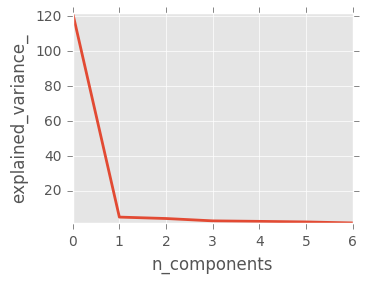

In [88]:
#Imprimimos el PCA y la varianza acorde al numero de componentes
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [89]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [90]:
#Hacemos KNN con los 7 componentes principales
KNN = KNeighborsClassifier(n_neighbors=3, weights="distance")
KNN.fit(x_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [91]:
pred_noprob = KNN.predict(x_test)
print("Resultado de Precisión del Modelo: {}".format(accuracy_score(y_test, pred_noprob)))

Resultado de Precisión del Modelo: 0.6024049513704686


## Modelo final selecccionado 
## BOSQUES ALEATORIOS

In [92]:
y = train["tipo_visita"]
x = train.drop("tipo_visita", axis=1).values.astype(float)

In [93]:
bosque = RandomForestClassifier(n_estimators = 300, max_features=2)

In [94]:
bosque = bosque.fit(np.asarray(x), np.asarray(y))

In [95]:
predicciones = bosque.predict_proba(np.asarray(test))
predicciones_noProba = bosque.predict(np.asarray(test))

In [96]:
predicciones_noProba

array([22, 27, 37, ...,  5, 24, 17])

In [97]:
len(predicciones_noProba)

95674

In [98]:
test.shape

(95674, 70)

In [99]:
def predictions_to_csv(test_predictions):
    test_predictions = pd.DataFrame(test_predictions)
    test_indexes = test.index
    test_predictions = test_predictions.rename(columns = {0:"TripType_3", 1: "TripType_4", 2: "TripType_5", 3: "TripType_6", 
                4: "TripType_7", 5: "TripType_8", 6: "TripType_9", 7: "TripType_12", 8: "TripType_14", 
                9: "TripType_15", 10: "TripType_18", 11: "TripType_19", 12: "TripType_20", 13: "TripType_21",
                14: "TripType_22", 15: "TripType_23", 16: "TripType_24", 17: "TripType_25", 18: "TripType_26", 
                19: "TripType_27", 20: "TripType_28", 21: "TripType_29", 22: "TripType_30", 23: "TripType_31", 
                24: "TripType_32", 25: "TripType_33", 26: "TripType_34", 27: "TripType_35", 28: "TripType_36", 
                29: "TripType_37", 30: "TripType_38", 31: "TripType_39", 32: "TripType_40", 33: "TripType_41", 
                34: "TripType_42", 35: "TripType_43", 36: "TripType_44", 37: "TripType_999"})
    test_predictions.insert(0, 'VisitNumber', test_indexes)
    return test_predictions.to_csv("submission.csv", index=False)

In [100]:
predictions_to_csv(predicciones)

In [101]:
!ls

README.md                           walmart-trip-classifier-final.ipynb
data                                walmart.png
submission.csv
